In [64]:
#Imports
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

In [65]:
#Function to pull in stock data
def stock_data(ticker, start_date, end_date, drop_extra_cols = True):
    try:
        # get ticker object
        ticker_data = yf.Ticker(ticker)
        # fetch data between start date ane end date
        df = ticker_data.history(start=start_date, end=end_date)
        # Drop unnecessary columns
        if len(df) > 0 and drop_extra_cols:
            df = df.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits" ], axis=1)
        return df
    
    except Exception as e:
        print(f"ERROR: An Error occurred while fetching and formatting data for {ticker} from yfinance  \n DETAILS: {repr(e)}")
        raise
        

In [66]:
#Get stock data 
# Calculate daily return and drop NaNs 
  
 
window = 5
start_date = "2011-01-01"
end_date = "2021-05-31"
ticker = "MSFT"
ticker_df = stock_data(ticker, start_date, end_date, drop_extra_cols = True)

ticker_df["Daily Return"] = ticker_df["Close"].pct_change().dropna()


ticker_df.dropna(inplace=True)
ticker_df.head()

,Close,Daily Return
Date,,
2011-01-04,22.230862,0.003932
2011-01-05,22.159628,-0.003204
2011-01-06,22.808588,0.029286
2011-01-07,22.634483,-0.007633
2011-01-10,22.333738,-0.013287


In [67]:
#Function that returns numpy array for X and y
def window_data(df, window, feature_col_number, target_col_number):
    
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [68]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using previous returns to predict future returns 
window_size = window

feature_column = 1
target_column = 1
X, y = window_data(ticker_df, window_size, feature_column, target_column)

In [69]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [70]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [71]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [72]:
#Import the models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [73]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [74]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [75]:
# Show the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 5)                

In [76]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
21/21 [==============================] - 5s 6ms/step - loss: 0.2250
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 0.1278
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0418
Epoch 4/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0167
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 8/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 9/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 10/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0143


In [77]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.0056074801832437515

In [78]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [79]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [80]:
#Create data frame with actual and predicted returns, trading signal, and entry/exit
actual_trading_signal = np.where(
    real_prices.ravel() > 0, 1.0, 0
)
predicted_trading_signal = np.where(
    predicted_prices.ravel() > 0, 1.0, 0
)
stocks = pd.DataFrame({
    "Actual Return": real_prices.ravel(),
    "Predicted Return": predicted_prices.ravel(),
    "Actual Trading Signal": actual_trading_signal,
    "Predicted Trading Signal": predicted_trading_signal,
 }, index = ticker_df.index[-len(real_prices): ]) 

stocks["Actual Entry/Exit"] = stocks["Actual Trading Signal"].diff()
stocks["Predicted Entry/Exit"] = stocks["Predicted Trading Signal"].diff()
stocks = stocks.dropna()
# Show the DataFrame's head
stocks.head(10)

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,
2018-04-20,-0.011549,-0.007177,0.0,0.0,0.0,0.0
2018-04-23,0.003684,-0.006445,1.0,0.0,1.0,0.0
2018-04-24,-0.023388,-0.006668,0.0,0.0,-1.0,0.0
2018-04-25,-0.008698,-0.007755,0.0,0.0,0.0,0.0
2018-04-26,0.021125,-0.008274,1.0,0.0,1.0,0.0
2018-04-27,0.016550,-0.008482,1.0,0.0,0.0,0.0
2018-04-30,-0.024004,-0.008110,0.0,0.0,-1.0,0.0
2018-05-01,0.015826,-0.008608,1.0,0.0,1.0,0.0
2018-05-02,-0.015684,-0.007278,0.0,0.0,-1.0,0.0


In [81]:
#export to csv
stocks.to_csv("lstm_daily_return.csv")

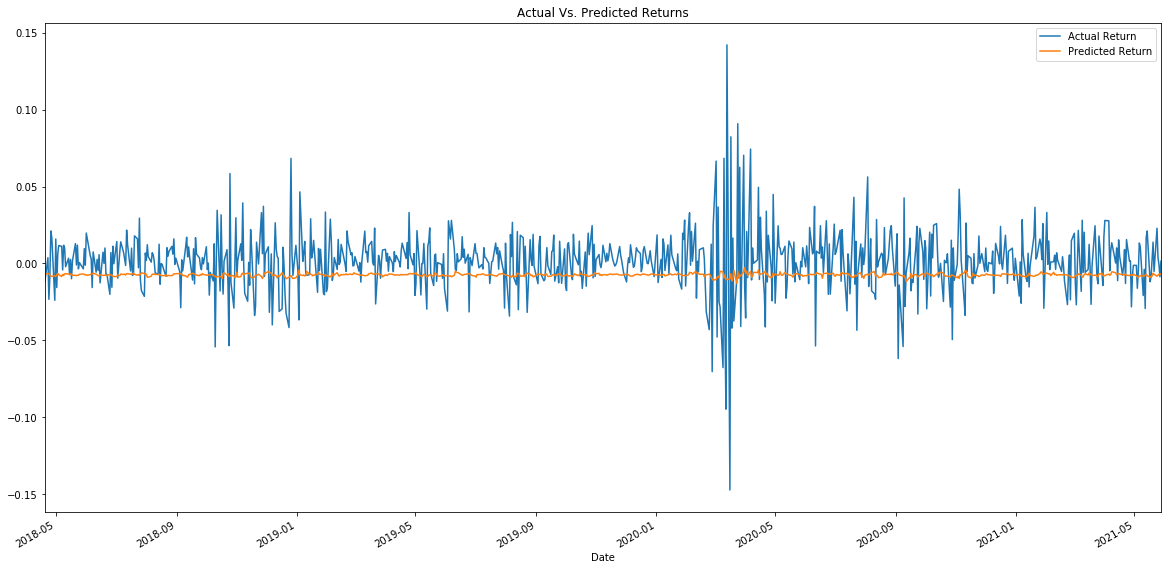

In [82]:
# Plot real returns vs predicted returns 
#Using previous returns to predict future returns
stocks[["Actual Return", "Predicted Return"]].plot(title="Actual Vs. Predicted Returns", figsize=(20,10))

##Reuse the data and functions to analyze rolling standard deviations ability to predict returns

In [84]:
#Get stock data 
# Calculate daily return and rolling standard deviation
window = 5
start_date = "2011-01-01"
end_date = "2021-05-31"
ticker = "MSFT"
ticker_df = stock_data(ticker, start_date, end_date, drop_extra_cols = True)

ticker_df["Daily Return"] = ticker_df["Close"].pct_change().dropna()
ticker_df["Rolling Std Dev"] = ticker_df["Daily Return"].rolling(window = window).std()
ticker_df.dropna(inplace=True)
ticker_df.head()

,Close,Daily Return,Rolling Std Dev
Date,,,
2011-01-10,22.333738,-0.013287,0.016596
2011-01-11,22.246687,-0.003898,0.016715
2011-01-12,22.594917,0.015653,0.017831
2011-01-13,22.309992,-0.012610,0.011824
2011-01-14,22.397053,0.003902,0.012145


In [85]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using rolling standard deviations of daily returns to predict future returns 

window_size = window

feature_column = 2
target_column = 1
X, y = window_data(ticker_df, window_size, feature_column, target_column)

In [86]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [87]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [88]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [89]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [90]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [91]:
# Show the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 5)                

In [92]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
21/21 [==============================] - 5s 7ms/step - loss: 0.2301
Epoch 2/10
21/21 [==============================] - 0s 7ms/step - loss: 0.1501
Epoch 3/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0637
Epoch 4/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0226
Epoch 5/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0178
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0153
Epoch 8/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 9/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0141
Epoch 10/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0136


In [93]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.004853450693190098

In [94]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [95]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [96]:
# Create a DataFrame of Real and Predicted values 

actual_trading_signal = np.where(
    real_prices.ravel() > 0, 1.0, 0
)
predicted_trading_signal = np.where(
    predicted_prices.ravel() > 0, 1.0, 0
)
std_dev = pd.DataFrame({
    "Actual Return": real_prices.ravel(),
    "Predicted Return": predicted_prices.ravel(),
    "Actual Trading Signal": actual_trading_signal,
    "Predicted Trading Signal": predicted_trading_signal,
 }, index = ticker_df.index[-len(real_prices): ]) 

std_dev["Actual Entry/Exit"] = std_dev["Actual Trading Signal"].diff()
std_dev["Predicted Entry/Exit"] = std_dev["Predicted Trading Signal"].diff()
std_dev = std_dev.dropna()
# Show the DataFrame's head
std_dev.head(10)

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,
2018-04-23,0.003684,-0.003041,1.0,0.0,1.0,0.0
2018-04-24,-0.023388,-0.003153,0.0,0.0,-1.0,0.0
2018-04-25,-0.008698,-0.003275,0.0,0.0,0.0,0.0
2018-04-26,0.021125,-0.003244,1.0,0.0,1.0,0.0
2018-04-27,0.016550,-0.003193,1.0,0.0,0.0,0.0
2018-04-30,-0.024004,-0.003203,0.0,0.0,-1.0,0.0
2018-05-01,0.015826,-0.003137,1.0,0.0,1.0,0.0
2018-05-02,-0.015684,-0.002981,0.0,0.0,-1.0,0.0
2018-05-03,0.005988,-0.002635,1.0,0.0,1.0,0.0


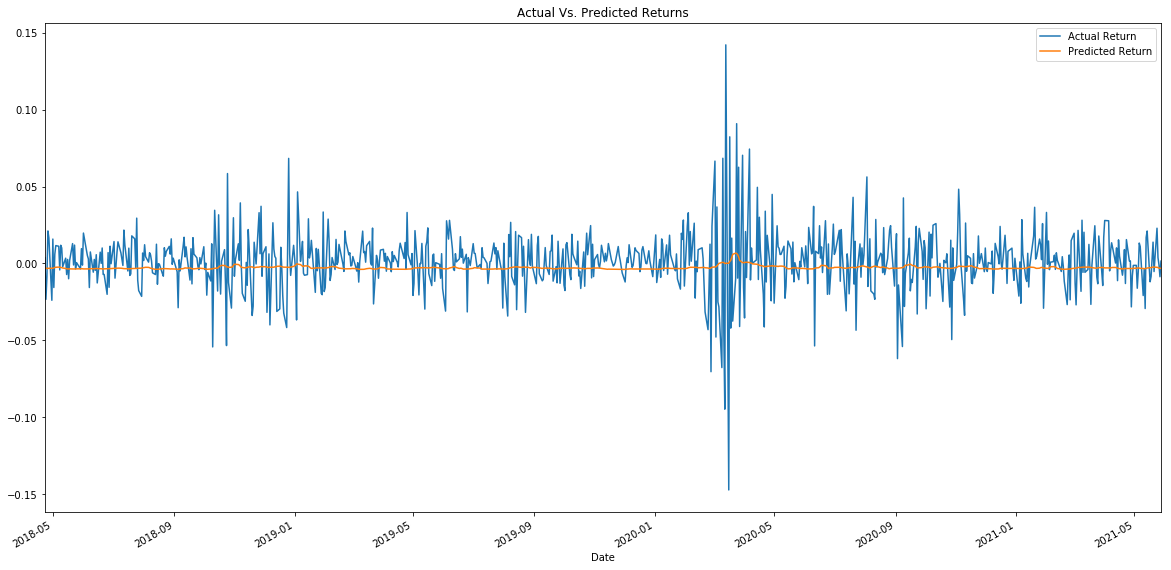

In [97]:
# Plot real returns vs predicted returns 
# Using rolling standard deviations of daily returns to predict future returns
std_dev[["Actual Return", "Predicted Return"]].plot(title="Actual Vs. Predicted Returns", figsize=(20,10))

In [98]:
#Export to csv
std_dev.to_csv("lstm_standard_dev_and_returns.csv")

# Use rolling standard deviations to predict closing prices and compare those daily returns to actual daily returns 

In [99]:
#Get stock data 
#Calculate daily returns and rolling standard deviation

window = 5
start_date = "2010-01-01"
end_date = "2020-12-31"
ticker = "MSFT"
ticker_df = stock_data(ticker, start_date, end_date, drop_extra_cols = True)

ticker_df["Daily Return"] = ticker_df["Close"].pct_change().dropna()
ticker_df["Rolling Std Dev"] = ticker_df["Daily Return"].rolling(window = window).std()
ticker_df.dropna(inplace=True)
ticker_df.head()

,Close,Daily Return,Rolling Std Dev
Date,,,
2010-01-11,23.467388,-0.012720,0.008034
2010-01-12,23.312330,-0.006607,0.007600
2010-01-13,23.529409,0.009312,0.010141
2010-01-14,24.002319,0.020099,0.013096
2010-01-15,23.924789,-0.003230,0.013202


In [100]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using rolling standard deviations of daily returns to predict future prices 

window_size = window

feature_column = 2
target_column = 0
X, y = window_data(ticker_df, window_size, feature_column, target_column)

In [101]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [102]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [103]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [104]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [105]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [106]:
# Show the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_21 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_22 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 5)                

In [107]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
22/22 [==============================] - 5s 6ms/step - loss: 0.0046
Epoch 2/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 3/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 4/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 5/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 6/10
22/22 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 7/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 8/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 9/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 10/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0052


In [108]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.25706300139427185

In [109]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [110]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [111]:
# Create a DataFrame of Real and Predicted values
std_dev_prices = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ticker_df.index[-len(real_prices): ]) 

std_dev_prices["Actual Return"] = std_dev_prices["Actual"].pct_change()
std_dev_prices["Predicted Return"] = std_dev_prices["Predicted"].pct_change()
std_dev_prices["Actual Trading Signal"] = np.where(
   std_dev_prices["Actual Return"] > 0, 1.0, 0 
)

std_dev_prices["Predicted Trading Signal"] = np.where(
    std_dev_prices["Predicted Return"] > 0, 1.0, 0
)
std_dev_prices["Actual Entry/Exit"] = std_dev_prices["Actual Trading Signal"].diff()
std_dev_prices["Predicted Entry/Exit"] = std_dev_prices["Predicted Trading Signal"].diff()
std_dev_prices = std_dev_prices.dropna()

# Show the DataFrame's head
std_dev_prices.head()

,Actual,Predicted,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,,,
2017-09-19,71.617722,35.275585,0.003726,-0.000054,1.0,0.0,1.0,0.0
2017-09-20,71.143036,35.273682,-0.006628,-0.000054,0.0,0.0,-1.0,0.0
2017-09-21,70.450020,35.271931,-0.009741,-0.000050,0.0,0.0,0.0,0.0
2017-09-22,70.639877,35.270309,0.002695,-0.000046,1.0,0.0,1.0,0.0
2017-09-25,69.548157,35.269424,-0.015455,-0.000025,0.0,0.0,-1.0,0.0


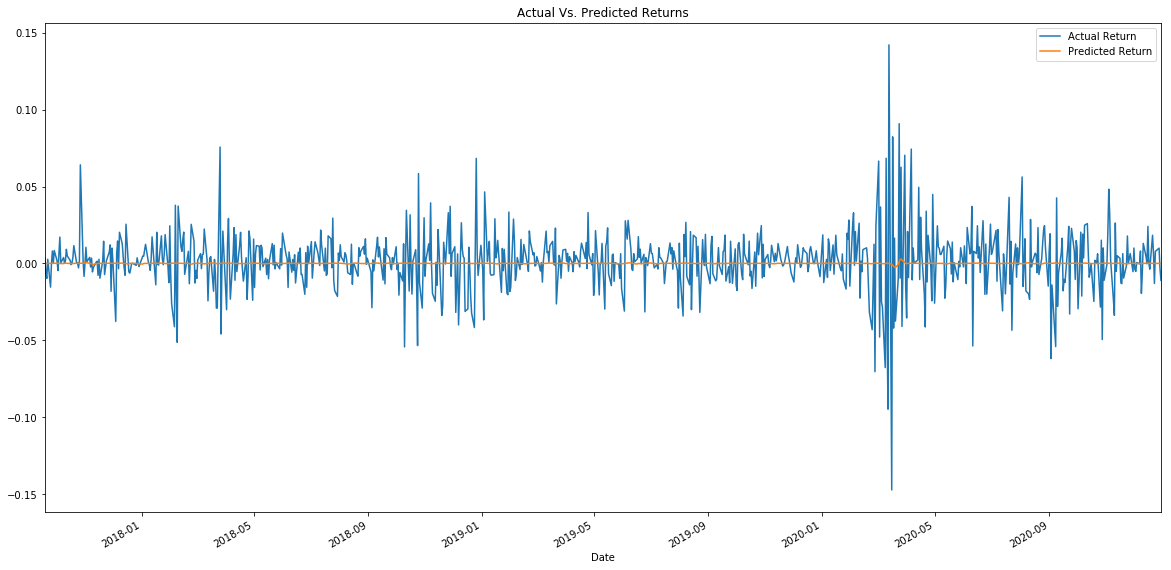

In [112]:
# Plot real returns vs predicted returns 
# Using rolling standard deviations of daily returns to predict future returns
std_dev_prices[["Actual Return", "Predicted Return"]].plot(title="Actual Vs. Predicted Returns", figsize=(20,10))

In [113]:
#Export to csv
std_dev_prices.to_csv("lstm_standard_dev_prices_returns.csv")

In [114]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)
trade_evaluation_df

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [115]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 100
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in std_dev_prices.iterrows():
    if row['Predicted Entry/Exit'] == 1:
        entry_date = index
        entry_share_price = row['Actual']
        entry_portfolio_holding = entry_share_price * share_size
        

    elif row['Predicted Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['Actual']) * share_size
        exit_share_price = row['Actual']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Stock': ticker,
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)
trade_evaluation_df["Cumulative Profit/Loss"] = trade_evaluation_df["Profit/Loss"].cumsum()
# Print the DataFrame
trade_evaluation_df

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss,Cumulative Profit/Loss
0,MSFT,2017-09-26,2017-10-05,100,69.548157,72.120842,6954.815674,7212.084198,257.268524,257.268524
1,MSFT,2017-10-10,2017-10-13,100,72.424637,73.563843,7242.463684,7356.384277,113.920593,371.189117
2,MSFT,2017-10-23,2017-11-07,100,74.835945,80.000305,7483.594513,8000.030518,516.436005,887.625122
3,MSFT,2017-11-21,2017-11-30,100,79.877327,80.306679,7987.732697,8030.667877,42.935181,930.560303
4,MSFT,2017-12-01,2017-12-12,100,80.392540,81.651955,8039.253998,8165.195465,125.941467,1056.501770
5,MSFT,2017-12-19,2017-12-26,100,81.890480,81.480217,8189.048004,8148.021698,-41.026306,1015.475464
6,MSFT,2018-01-05,2018-01-25,100,84.142174,88.092133,8414.217377,8809.213257,394.995880,1410.471344
7,MSFT,2018-02-01,2018-02-14,100,89.933556,87.048904,8993.355560,8704.890442,-288.465118,1122.006226
8,MSFT,2018-02-15,2018-02-20,100,88.822281,88.879791,8882.228088,8887.979126,5.751038,1127.757263
9,MSFT,2018-02-26,2018-03-07,100,91.467964,89.972580,9146.796417,8997.257996,-149.538422,978.218842
